# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import alpaca_trade_api as tradeapi #####Commenting the deprecated way to call the API
from alpaca_trade_api.rest import REST, TimeFrame 
from dotenv import load_dotenv 
from MCForecastTools import MCSimulation
from datetime import datetime

debugtoggle = True

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC  and ETH price
# YOUR CODE HERE!
response_data_btc = requests.get(btc_url).json()
response_data_eth = requests.get(eth_url).json()


price_btc = float(response_data_btc["data"]["1"]["quotes"]["CAD"]["price"])
price_eth = float(response_data_eth["data"]["1027"]["quotes"]["CAD"]["price"])

# Compute current value of my crpto
my_btc_value = my_btc * price_btc
my_eth_value = my_eth * price_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f} in CAD")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f} in CAD")

The current value of your 1.2 BTC is $37196.84 in CAD
The current value of your 5.3 ETH is $12723.82 in CAD


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
api_key=os.getenv("ALPACA_API_KEY")

# Create the Alpaca API object
api_secret_key=os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = REST(api_key , api_secret_key, api_version='v2')

In [12]:
# Format current date as ISO format
start_date = "2022-08-09"
end_date = "2022-08-09"

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
api = REST(api_key , api_secret_key, api_version='v2')
stock_and_bond_prices = api.get_bars(tickers, TimeFrame.Day, start_date, end_date, adjustment='raw').df
stock_and_bond_prices.index = stock_and_bond_prices.index.date

# Preview DataFrame
print(f'{stock_and_bond_prices.head()}')

              open     high     low   close    volume  trade_count  \
2022-08-09  102.92  103.045  102.84  102.95   3849491        17130   
2022-08-09  412.30  412.750  410.22  411.35  44110509       366275   

                  vwap symbol  
2022-08-09  102.948831    AGG  
2022-08-09  411.331714    SPY  


In [13]:
# Pick AGG and SPY close prices
close_agg = stock_and_bond_prices[(stock_and_bond_prices['symbol']=='AGG')]
close_spy = stock_and_bond_prices[(stock_and_bond_prices['symbol']=='SPY')]

agg_close_price = close_agg['close'][0]
spy_close_price = close_spy['close'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $102.95
Current SPY closing price: $411.35


In [14]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:,.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:,.2f}")

The current value of your 50 SPY shares is $20,567.50
The current value of your 200 AGG shares is $20,590.00


### Savings Health Analysis

In [15]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
shares = my_spy_value + my_agg_value
crypto = my_btc_value + my_eth_value

# Create savings DataFrame
df_saving = {'crypto': crypto, 'shares': shares}
df_savings = pd.DataFrame.from_dict(df_saving, orient='Index', columns=['Amount'])

# Display savings DataFrame
display(df_savings)

,Amount
crypto,49920.654523
shares,41157.500000


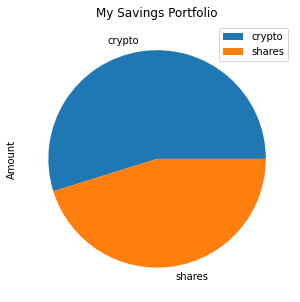

In [19]:
# Plot savings pie chart
df_savings.plot.pie(y='Amount',title='My Savings Portfolio', figsize=(5,5))
plt.show()

In [21]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto + shares
reach_goal = total_savings - emergency_fund

# Validate saving health
if total_savings > emergency_fund:
    print('Congratulations! You have enough money in your savings fund')
elif total_savings == emergency_fund: 
    print('Congratulations! You have reached your financial goal')
else:
    diff_efund == (emergency_fund - total_savings)
    print(f"Keep up the good work... You're ${diff_efund} away from reaching your financial goal")

Congratulations! You have enough money in your savings fund


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [22]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-08-09', tz='America/New_York').isoformat()

In [23]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
api = REST(api_key , api_secret_key, api_version='v2')
df_stock_data = api.get_bars(tickers, TimeFrame.Day, start_date, end_date, adjustment='raw').df
df_stock_data.index=df_stock_data.index.date
df_stock_data=df_stock_data[['close', 'symbol']]

# Display sample data
df_stock_data.head()

,close,symbol
2017-05-01,108.73,AGG
2017-05-02,108.88,AGG
2017-05-03,108.77,AGG
2017-05-04,108.68,AGG
2017-05-05,108.70,AGG


In [24]:
# seperating the df
AGG = df_stock_data[df_stock_data["symbol"]=="AGG"].drop("symbol", axis=1)
SPY = df_stock_data[df_stock_data["symbol"]=="SPY"].drop("symbol", axis=1)

In [25]:
#concatenating AGg and SPY
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=["AGG","SPY"])
df_stock_data.head()

,AGG,SPY
,close,close
2017-05-01,108.73,238.68
2017-05-02,108.88,238.77
2017-05-03,108.77,238.48
2017-05-04,108.68,238.76
2017-05-05,108.70,239.70


In [28]:
# Configuring a Monte Carlo simulation to forecast thirty years cumulative returns

# Assum a traditional 40/60 portfolio using the SPY and AGG tickers to represent 
# the 60% stocks (SPY) and 40% bonds (AGG) composition of the portfolio. 

MC_Sim = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [29]:
# Printing the simulation input data
print(MC_Sim)

In [30]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_Sim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 110.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 120.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 130.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 140.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 150.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 160.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 170.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 180.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 190.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 200.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 210.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 220.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 230.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 240.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 250.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 260.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 270.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 280.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 290.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 300.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 310.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 320.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 330.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 340.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 350.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 360.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 370.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 380.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 390.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 400.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 410.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 420.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 430.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 440.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 450.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 460.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 470.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 480.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

Running Monte Carlo simulation number 490.


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\I

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994533,0.988927,0.990794,1.007912,0.984991,0.998194,0.997018,1.008481,0.987679,0.995638,...,0.996876,1.002586,0.993140,1.010710,1.001901,1.008878,0.996906,0.998447,1.000970,0.999932
2,0.990358,0.977386,0.999499,1.012062,0.973825,0.997901,0.989089,1.010402,0.982196,0.997780,...,0.990288,1.006599,1.002061,1.014817,1.025100,1.006120,0.991908,0.995741,0.992718,0.995816
3,0.985436,0.969868,1.001436,1.018999,0.963854,0.998147,0.984529,1.014539,0.988872,1.006251,...,1.001436,1.005507,0.996542,1.021187,1.004007,1.007769,1.005955,1.008319,1.001899,0.998022
4,0.999526,0.968884,1.009819,1.017205,0.966475,0.992745,0.988840,1.015502,0.989462,1.000552,...,0.992678,1.029434,0.997929,1.027608,0.998899,1.007244,0.997108,1.013740,1.014903,1.000876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,9.356538,3.108862,19.747773,5.730257,12.267202,29.227880,10.504299,13.065176,6.416112,10.445703,...,6.590007,3.342956,3.891822,6.280334,19.510274,4.503544,7.298000,9.997312,12.930215,18.500354
7557,9.443208,3.141901,19.611166,5.773818,12.280426,29.064785,10.561058,13.213028,6.430932,10.611288,...,6.593462,3.313957,3.898913,6.299785,19.572014,4.510505,7.146423,9.997585,12.961493,18.387231
7558,9.409792,3.166002,19.709609,5.778813,12.294384,29.103959,10.601124,13.255351,6.472254,10.626588,...,6.667691,3.318470,3.950470,6.265281,19.671401,4.477607,7.155033,10.094969,12.985393,18.304547
7559,9.434862,3.138426,19.496251,5.731555,12.224121,29.588666,10.610054,13.328190,6.511431,10.745457,...,6.638013,3.291635,3.949923,6.348433,19.654697,4.466648,7.125825,10.013682,12.790408,18.134653


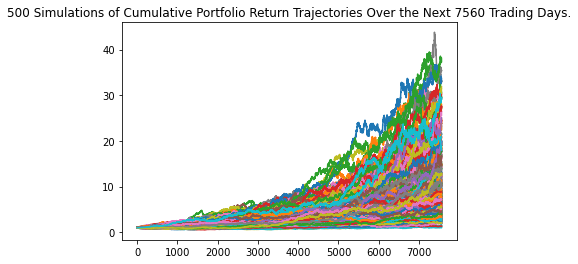

In [37]:
# Plot simulation outcomes
line_plot = MC_Sim.plot_simulation()
line_plot.get_figure().savefig("MC_Sim_30_years_sim_plot.png", bbox_inches="tight")
plt.show()

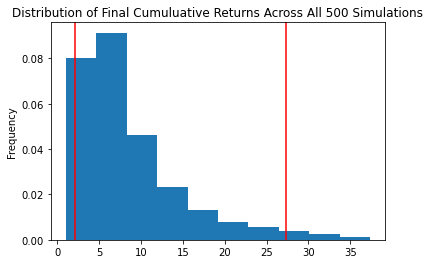

In [35]:
# Plot probability distribution and confidence intervals
dist_plot = MC_Sim.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_Sim_30_years_dist_plot.png',bbox_inches='tight')
plt.show()

### Retirement Analysis

In [38]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_stat = MC_Sim.summarize_cumulative_return()

# Print summary statistics
print(mc_stat)

count           500.000000
mean              8.641906
std               6.330844
min               1.021224
25%               4.379108
50%               6.908964
75%              10.667330
max              37.383281
95% CI Lower      2.094401
95% CI Upper     27.303103
Name: 7560, dtype: float64


C:\Users\salma\UTOR-VIRT-FIN-PT-02-2022-U-LOL-main\Homeworks\05-APIs\Instructions\Starter_Code\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [41]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(mc_stat[8]*initial_investment,2)
ci_upper = round(mc_stat[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio" 
      f" over the next 30 years will end within in the range of" 
      f" ${ci_lower:,} and ${ci_upper:,}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $41,888.01 and $546,062.06


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [42]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(mc_stat[8]*initial_investment,2)
ci_upper = round(mc_stat[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $41888.01 and $546062.06


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001799,1.000245,1.006243,0.995742,1.003219,0.998395,0.997985,1.004253,1.002497,0.998947,...,1.007121,1.004291,1.000334,1.000876,0.998973,1.001375,0.996477,1.002103,1.005063,0.995521
2,0.998289,1.000243,1.004284,0.996554,1.004502,0.993317,0.996037,1.010316,1.000850,0.996382,...,1.007016,1.003709,0.999542,1.001450,1.004142,1.004022,0.996702,1.004359,1.009205,0.999000
3,1.002639,0.997279,1.008339,0.992870,0.998657,0.989041,0.994189,1.010062,0.999200,0.999132,...,1.004156,1.002288,1.003976,0.994908,1.008989,1.004545,0.995074,1.010488,1.011124,1.002626
4,1.008853,0.996292,1.002813,0.995244,0.996794,0.990576,0.999322,1.010897,0.989222,0.995257,...,1.000057,1.007349,1.006909,0.990823,1.013085,1.002427,0.996293,1.007081,1.010369,0.998654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.438618,0.926659,1.048662,1.101424,1.134443,1.200987,1.347489,1.257520,1.428939,1.194429,...,1.104654,1.273680,1.276718,1.297344,1.229379,1.295593,1.501864,1.198438,1.386161,1.426163
1257,1.441785,0.926428,1.048574,1.104941,1.137374,1.204559,1.360843,1.260661,1.429710,1.201055,...,1.107447,1.269262,1.265880,1.296800,1.227049,1.297884,1.510874,1.190802,1.388448,1.427391
1258,1.444675,0.931714,1.053040,1.110206,1.140592,1.199869,1.358605,1.254728,1.426409,1.207420,...,1.101690,1.274683,1.281527,1.303255,1.227517,1.294870,1.503567,1.191945,1.388434,1.441467
1259,1.443488,0.934065,1.049921,1.108998,1.142538,1.203844,1.363563,1.254192,1.425030,1.213366,...,1.103902,1.276629,1.275813,1.296929,1.222773,1.285521,1.498580,1.192940,1.397786,1.440244


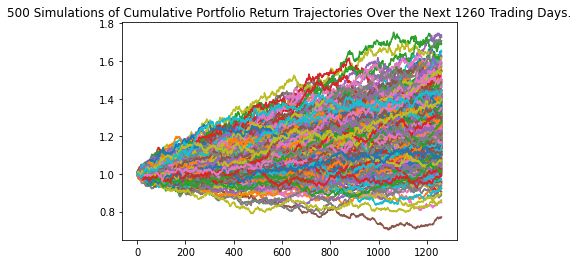

In [26]:
# Plot simulation outcomes
# YOUR CODE HERE!

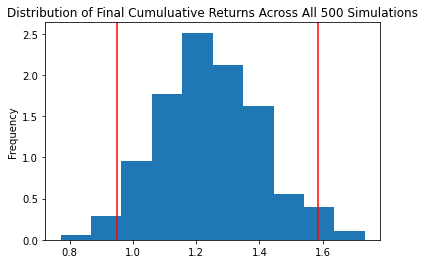

In [27]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.245905
std               0.160008
min               0.771559
25%               1.140795
50%               1.232555
75%               1.352284
max               1.733421
95% CI Lower      0.951523
95% CI Upper      1.586592
Name: 1260, dtype: float64


In [29]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57091.37 and $95195.55


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004461,1.003269,0.998934,0.996767,1.000906,0.999279,0.995262,1.005752,0.993466,0.993655,...,1.001427,1.004350,0.996932,0.996844,0.997507,1.003457,0.998736,1.001195,0.999904,1.010218
2,1.007901,1.003304,0.993812,0.999973,1.000910,1.002347,0.996311,1.007234,0.993550,0.991021,...,0.997379,1.001952,0.998124,0.998063,1.001733,1.000273,0.994865,1.000109,0.994648,1.007838
3,1.007532,1.001077,0.990963,0.998339,1.001779,1.003653,0.994439,1.012230,0.999170,0.996484,...,0.995265,1.001745,0.995332,1.003023,1.003800,0.999755,0.997616,1.004730,0.993391,1.010444
4,1.020339,1.005743,0.991869,0.998218,1.005630,1.008717,0.987764,1.012750,0.999227,0.996474,...,0.999028,1.004730,0.995357,1.000204,1.008738,0.999273,0.999426,1.003776,0.991478,1.013379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.616922,1.761703,1.143430,1.687801,1.743826,1.174891,1.514199,2.447129,1.589765,1.570578,...,1.316494,1.863650,1.727959,1.411033,1.804671,1.500605,1.413278,1.552375,1.318340,1.960015
2517,1.620285,1.769184,1.145132,1.695693,1.742878,1.175745,1.517697,2.441471,1.586174,1.560826,...,1.318463,1.857860,1.724003,1.409092,1.810136,1.499466,1.413210,1.552539,1.316872,1.956776
2518,1.622141,1.771927,1.149019,1.691589,1.739420,1.178965,1.522624,2.444413,1.580680,1.566154,...,1.317147,1.864694,1.727503,1.419561,1.821212,1.492831,1.412283,1.556659,1.318842,1.961271
2519,1.628885,1.770207,1.149670,1.703935,1.738053,1.182429,1.519485,2.441360,1.565663,1.576607,...,1.307985,1.858986,1.728039,1.430017,1.814690,1.496851,1.409284,1.562660,1.324798,1.964190


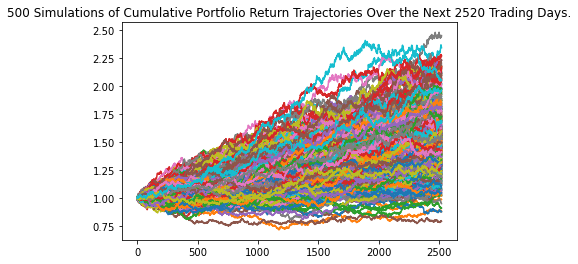

In [32]:
# Plot simulation outcomes
# YOUR CODE HERE!

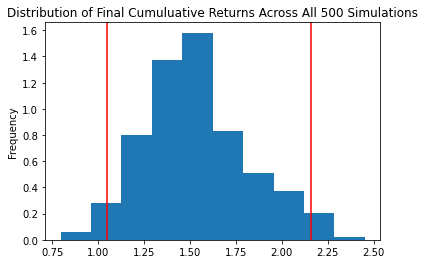

In [33]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.537014
std               0.282192
min               0.795263
25%               1.339641
50%               1.523799
75%               1.693927
max               2.451787
95% CI Lower      1.049781
95% CI Upper      2.159935
Name: 2520, dtype: float64


In [35]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $62986.85 and $129596.12
